## Expectation-Maximization
- EM is an algorithm for maximum likelihood optimization when there is missing information - oir when it is useful to add latent augmented variables to simplify maximum likelihood calculations

## Maximum Likelihood with complete information
- Suppose we have an experiment with coin A that has probability $\theta_A$ of heads and coin B that has probability $\theta_B$ of tails
- Draw m samples as follows: for each sample, pick one of the coins at random, flip it n times and record the number of heads and tails ($n_H + n_T = n$)
- if we recorded which coin we used for each sample, then we have __complete__ information and can estimate $\theta_A$ and $\theta_B$.  For example: Suppose we draw 5 samples and sequence of coin chosen is A, A, B, A, B
and let the number of heads and tails in each sample represented by vector x.  Then complete loglikelihood is

$$ \log{p(x_1; \theta_A)} + \log{p(x_1; \theta_A)} + \log{p(x_1; \theta_B)} + \log{p(x_1; \theta_A)} + \log{p(x_1; \theta_B)} $$

where $\log{p(x; \theta)}$ is binomial pmf with $n = m$ and $p = \theta$
- let $z_i$ be the label of the $i^{th}$ coin


In [1]:
from scipy.optimize import minimize
import pandas as pd
from scipy.stats import bernoulli, binom
import numpy as np
def neg_loglik(thetas, n, xs, zs):
    return -np.sum([binom(n, thetas[z]).logpmf(x) for (x, z) in zip(xs, zs)])

In [2]:
m = 10 # 10 tosses of each coin
theta_A = 0.8
theta_B = 0.3
theta_0 = [theta_A, theta_B]

coin_A = bernoulli(theta_A)
coin_B = bernoulli(theta_B)

xs = np.array(list(map(sum, [coin_A.rvs(m), coin_A.rvs(m), coin_B.rvs(m), coin_A.rvs(m), coin_B.rvs(m)])))
zs = [0, 0, 1, 0, 1]

In [3]:
# total successes in each trial
xs

array([6, 8, 4, 7, 5])

In [4]:
# mle for binomial is phat = sum(xi)/n, i = 1: n where n is number of trials
ml_A = np.sum(xs[[0,1,3]])/(3.0*m)
ml_B = np.sum(xs[[2,4]])/(2.0*m)
ml_A, ml_B

(0.7, 0.45)

In [5]:
# numerically lets estimate the theta
bnds = [(0,1), (0,1)]
minimize(neg_loglik, [0.5, 0.5], args=(m, xs, zs),
         bounds=bnds, method='tnc', options={'maxiter': 100})['x']


array([0.69999982, 0.45000077])

## Incomplete information
- we can see that in the case of complete information, it is pretty easy to estimate the theta
- if we did not record the coin we used, we have missing data and problem of estimating $\theta$ is harder to solve
- Ask a different question: can we assign weights $w_i$ to each sample according to how likely it is to be generated from coin A or coin B
- with knowledge of $w_i$, we can maximize likelihood to find $\theta$.  So, start with a guess of $\theta$, then calculate z, then update $\theta$ using the new value of z and repeat until convergence.  This is the EM algorithm
- in other words, since we dont know the label of ith coin, we can use bayes theorem.  this is the Eth step.  ex: suppose $\theta_A$ = 0.4 and $\theta_B = 0.7$.  We observe the following flips: HHHHHHHHTT.  Let E be the event that this sequence occurs.  Let $Z_A$ be event we chose coin A and $Z_B$ be event we chose coin B.  What is $P(E | Z_A)$? Conduct another trial with E = HHHHHTTTTT with $\theta_A = 0.4$ and $\theta_B = 0.6$
- Clearly, given we know which coin was chosen, the probability of observing k successes in m trials is binomail with parmaters(m, p)


In [6]:
# since there are 8 heads and 2 tails
p_EA =  binom(10, 0.4).pmf(8)
manual = (10 * 9 / 2) * 0.4**8 * 0.6**2
p_EA, manual # matches

(0.010616832, 0.010616832000000005)

In [7]:
p_EB = binom(10, 0.7).pmf(8)
manual = (10 * 9 / 2) * 0.7**8 * 0.3**2

In [8]:
binom(10, 0.7).pmf(8)

0.23347444049999988

In [9]:
45 * 0.7**8 * 0.3**2

0.23347444049999988

In [10]:
p_EB, manual

(0.23347444049999988, 0.23347444049999988)

Due to bayes theorem, we know that: 

$$ P(Z_A | E) = \frac{P(E | Z_A)P(Z_A)}{P(E|Z_A)P(Z_A) + P(E | Z_B)P(Z_B)}$$

and since $P(Z_A) = P(Z_B) = \frac{1}{2}$, wee see that: 

In [11]:
pZ_AE = p_EA / (p_EA + p_EB )
pZ_BE = p_EB  / (p_EA + p_EB )
pZ_AE, pZ_BE

(0.04349533636029533, 0.9565046636397047)

- Hence, much more likely to have come from coin B rather than A.  If we repeat another trial, we will see that they are both equally likely to have come from coin A or coinB

In [12]:
# 2nd trial
p_EA =  binom(10, 0.4).pmf(5)
p_EB = binom(10, 0.6).pmf(5)
pZ_AE = p_EA / (p_EA + p_EB )
pZ_BE = p_EB  / (p_EA + p_EB )
pZ_AE, pZ_BE

(0.5, 0.5)

More generally, for a given trial E with number of heads $h$ and number of tails $t = 10 - h$: 

$$ P(Z_A | E) = \frac{\theta_A^h (1-\theta_A)^t}{\theta_A^h (1-\theta_A)^t + \theta_B^h (1-\theta_B)^t}$$

and 

$$ P(Z_B | E) = \frac{\theta_B^h (1-\theta_B)^t}{\theta_A^h (1-\theta_A)^t + \theta_B^h (1-\theta_B)^t}$$

### Assigning expected number of flips to each coin
- Now that we have an estimate of relative likelihood each coin was chosen, we can estimate the number of  heads and tails for each coin by multiplying these probabilities by number of heads and tails in trial.  Assume $\theta_A^0 = 0.6$ and $\theta_B^0 = 0.5$ for initial estimate

In [13]:
trials = [[1,0,0,0,1,1,0,1,0,1], [1,1,1,1,0,1,1,1,1,1], [1,0,1,1,1,1,1,0,1,1], [1,0,1,0,0,0,1,1,0,0],
[0,1,1,1,0,1,1,1,0,1]]
total_heads = np.array(list(map(sum, trials)))
total_tails = np.array(list(map(lambda x,y: len(x) - y, trials, total_heads)))
p_EA = np.array([binom(10, 0.6).pmf(i) for i in total_heads])
p_EB =  np.array([binom(10, 0.5).pmf(i) for i in total_heads])
dd = np.vectorize({0: 'H',1: 'T'}.get)
trials = dd(trials)
n = trials.shape[0]
flips = ["".join(trials[i]) for i in range(n)]
pZ_AE = p_EA / (p_EA + p_EB )
pZ_BE = p_EB  / (p_EA + p_EB )
heads_due_to_A = pZ_AE * total_heads
tails_due_to_A = pZ_AE * total_tails
heads_due_to_B = pZ_BE * total_heads
df = pd.DataFrame(np.column_stack((pZ_AE, pZ_BE, heads_due_to_A, heads_due_to_B)))
df['flips'] = flips
df.columns = ['probability it was coin A',
'probability it was coin B',
'# heads attributed to A',
'# heads attributed to B', 'flips']

In [14]:

df.round(2)

,probability it was coin A,probability it was coin B,# heads attributed to A,# heads attributed to B,flips
0,0.45,0.55,2.25,2.75,THHHTTHTHT
1,0.80,0.20,7.24,1.76,TTTTHTTTTT
2,0.73,0.27,5.87,2.13,THTTTTTHTT
3,0.35,0.65,1.41,2.59,THTHHHTTHH
4,0.65,0.35,4.53,2.47,HTTTHTTTHT


## M-Step
- Once we have estimate of number of heads attributed to each coin, we need to update the estimate. 
- To update the estimate, use expected number of heads divided by total number of trials, i.e 

$\theta_A^1 = \frac{2.25 + 7.24 + 5.87 + 1.41 + 4.53}{10 * (0.45 + 0.8 + 0.73 + 0.35 + 0.65)} = 0.71$

$\theta_B^1 = \frac{2.75 + 1.76 + 2.13 + 2.59 + 2.47}{10 * (0.55 + 0.2 + 0.27 + 0.65 + 0.35)} = 0.58$

- We are maximizing the likelihood of the flip counts we estimated in the E-step by assuming coin biases are matched up proportionally.  
- With updated parameters, we can repeat E-step again.  
 
To review, we took a problem of estimating coin biases that would be easy if we have complete data, that is, if we knew which coin was chosen, and made it tractable by iteratively: 
 - Assuming we have the coin biases, computing expected number of heads and tails for each coin for the trials we see (E-step)
 - Given these counts of heads and tails, providing improved guess at the coin biases by simply dividing the number of heads by total flips of each coin. 

### __EM in General__

More Generally, EM algorithm helps us estimate parameters of probability distribution where: 
- We are given samples from distribution where some of the variables are missing
- if we had access to these missing values, estimating the parameters would be easy

by iteratively: 
- Guessing the parameters of distribution and  using this to fill in values of the missing data (E-step)
- with these estimates for missing data in hand, easily updating values  of our model

In [15]:
(heads_due_to_A.sum() / (10*pZ_AE.sum())).round(2), (heads_due_to_B.sum() / (10*pZ_BE.sum())).round(2), 

(0.71, 0.58)

In [16]:
heads_due_to_A.sum() / (heads_due_to_A.sum() + tails_due_to_A.sum())

0.7130122354005162

In [17]:
from marketlearn.learning.mixture.coin_mixture import CoinMixture
from scipy.stats import bernoulli, binom
trials = np.array([[1,0,0,0,1,1,0,1,0,1], [1,1,1,1,0,1,1,1,1,1], [1,0,1,1,1,1,1,0,1,1], [1,0,1,0,0,0,1,1,0,0],
[0,1,1,1,0,1,1,1,0,1]])
m = 100 # 100 tosses of each coin
theta_A = 0.8
theta_B = 0.1
coin_A = bernoulli(theta_A)
coin_B = bernoulli(theta_B)
trials = np.vstack([coin_A.rvs(m), coin_A.rvs(m), coin_B.rvs(m), coin_A.rvs(m), coin_B.rvs(m)])

In [18]:
cm = CoinMixture(n_coins=2, m_flips=m, max_iter=50);
from numpy.random import sample
#guess = np.concatenate(([0.5, 0.5], sample(2)))
cm.fit(trials);

In [19]:
cm.theta.tail()

,p(z=0),p(z=1),thetaA,thetaB
45,0.4,0.6,0.075,0.796667
46,0.4,0.6,0.075,0.796667
47,0.4,0.6,0.075,0.796667
48,0.4,0.6,0.075,0.796667
49,0.4,0.6,0.075,0.796667


In [37]:
import string
string.ascii_uppercase
" ".join(("p(z={i})".format(i=i) for i in range(2)))
" ".join(("theta{i}".format(i=i) for i in dict(zip(range(2), string.ascii_uppercase)).values()))

'ABCDEFGHIJKLMNOPQRSTUVWXYZ'

'p(z=0) p(z=1)'

'thetaA thetaB'

In [5]:
from itertools import chain
for i in chain([2,3], [3,7]):
    print(i)

2
3
3
7


## Another example - Density Estimation
- Lets conduct the following experiment: let there be 2 trials.  For first trial, draw 100 rvs thats Normally distributed with mean 1, variance 1.  For 2nd trial, draw another 100 rvs thats normally distributed with mean 10, and variance 1.  
- Append the 200 observations into a single array.  Call this new array x.  Question: What is the distribution of x?  
- We know its a mixture of two normally distributed normal rvs.  But we cant fit loglikelihood of a single normally distributed rv
- if we know the label where ith observation belongs to, then we can, for ex: 

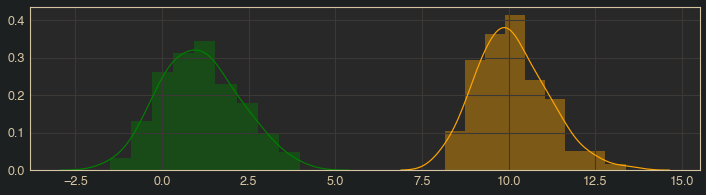

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt
N = 100
mu_arr = np.array([1, 10])
sigma_arr = np.array([1, 1])
xs = np.append(np.random.normal(mu_arr[0], sigma_arr[0], N), 
              np.random.normal(mu_arr[1], sigma_arr[1], N))
fig, ax = plt.subplots(figsize=(12,3))

# i know first 100 is from mu1 and next 100 from mu2
sns.distplot(xs[:N], color='green');
sns.distplot(xs[N:], color='orange');

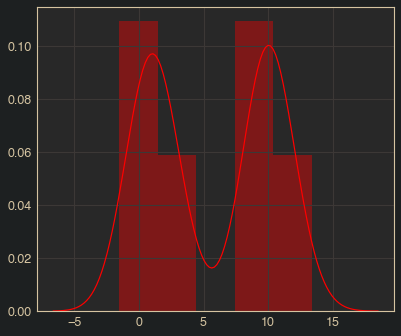

In [21]:
# when we do not know, it doesn't fit very well
np.random.shuffle(xs)
sns.distplot(xs, color='red') # when we do not know 

In [25]:
## Using scipy, estimate parameters of above model.  Assume first 100 came from first normal, 
## next 100 came from another normal.  
from scipy.stats import norm
from scipy.optimize import minimize
mu_1 = 1
mu_2 = 10
sig_1 = 1
sig_2 = 1
thetas = [mu_1, mu_2, sig_1, sig_2]

zs = [0, 1]

def neg_loglik(thetas, xs):
    ys = np.append(norm(loc=thetas[0], scale=thetas[2]).logpdf(xs[:N]),
    norm(loc=thetas[1], scale=thetas[3]).logpdf(xs[N:]))
    return -ys.sum()

def neg_logliknorm(thetas, xs):
    return -np.sum(norm(loc=thetas[0], scale=thetas[1]).logpdf(xs)) 

In [26]:
test = np.random.normal(4, 1, 1000)

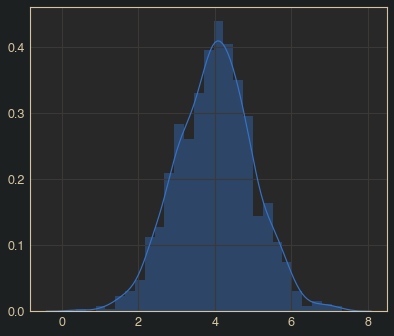

In [27]:
sns.distplot(test);

In [28]:
thetas = [1,1]
minimize(neg_logliknorm, thetas, args=(test,), method='slsqp')['x']

array([4.00017588, 0.99181232])

In [29]:
# lets try mixture
thetas = [1, 10, 1, 1]
xs = np.append(np.random.normal(thetas[0], thetas[2], N), 
              np.random.normal(thetas[1], thetas[3], N))
minimize(neg_loglik, [2,5,3.5,4.2], args=(xs,), method='slsqp')['x']
# matches well aka, its easy peazy

array([ 1.10065768, 10.04439009,  0.88153485,  0.86853541])

- suppose we have a 1-dimensional data denoted by $x = (x^{1}, \ldots, x^m)$ as shown above consisting of m independent samples
- we do not know the real labels for each data point in reality.  This introduces a latent (hidden/unobserved) variable called $z = (z^1, \ldots, z^m)$ which is multinomial: $z^i$ indicates which distribution a specific point $x^i$ belongs to.  $Z^i$ follows a bernoulli since it can belong to one of two values
- so goal is to fit parameters of a model $p(x,z)$.  we  have $p(x,z;\theta)$ where only x is observed.  Goal is to maximize $l(\theta) = \prod_{i} p(x^i;\theta)$.  This is the incomplete data log likelihood because we do not know the latent variable z that indiate each datapoint's membership to density which a data point belongs to.  
- if we know which datapoint $z^i$ belongs to, then its easy to estimate the parameters
- if we do not know, maximum likelihood doesn't work as there is no closed form solution: 

$$ l(\theta) = \prod_{i} p(x^i;\theta) = \prod_{i} \sum_k^K \pi_k N(\mu_k, \sigma_k^2)$$

where $\pi_k = p(z^i = k)$.  Taking loglikelihood, we see: 

$$ l(\theta) = \sum_{i} \log{p(x^i;\theta)} = \sum_{i} \log{\sum_k^K \pi_k N(\mu_k, \sigma_k^2)}$$

Differentiating above wrt $\mu_k$ gives: 

$$ \sum_i \frac{\pi_k N(\mu_k, \sigma_k^2) \frac{x^i - \mu_k}{\sigma_k^2}} {\sum_{k=1}^K \pi_k N(\mu_k, \sigma_k^2)} = 0$$

- No way to solve for $\mu_k$ here

- EM algorithm gives an efficient way of maximizing likelihood estimation
- maximizing $l(\theta)$ is difficult.  We will repeatedly construct a lower bound on $l$ (E-step) and optimize
lower bound (M-step)

## EM algorithm formulation
- $l(\theta) = \sum_i \log{\sum_{z^i} p(x^i, z^i; \theta)} = \sum_i \log{\sum_{z^i} q_i(z^i) \frac{p(x^i, z^i; \theta)}{q_i(z^i)}}$

where $q_i(z^i)$ is arbitrary probability distribution of $z^i$ whose sum equals 1.
- Note that: $\frac{p(x^i, z^i; \theta)}{q_i(z^i)}$ takes form of expectation.  Hence we see above likelihood can be rewritten as: 

$$l(\theta) = \sum_i \log{E[\frac{p(x^i, z^i; \theta)}{q_i(z^i)}]}$$

and by jensen's inequality, $E(f(x) >= f(E(x))$, hence: 

$$\sum_i \log{E[\frac{p(x^i, z^i; \theta)}{q_i(z^i)}]} >= \sum_i q_i(z^i) \log{\frac{p(x^i, z^i; \theta)}{q_i(z^i)}}$$
- hence we have successfully created a lower bound for $l(\theta)$.  This is not enough, we want to squeeze the lower bound as much as possible to obtain an __equality__.  So, we need: 

$$ \frac{p(x^i, z^i; \theta)}{q_i(z^i)} = c$$

where c is some constant.  On way to ensure this leads to a constant is to choose $q_i(z^i) \propto p(x^i, z^i; \theta)$ s.t $\sum_i q_i(z^i) = 1$.  From this, we can determine the appropriate choice of __q__:

$$ q_i(z^i) = \frac{p(x^i, z^i; \theta)}{\sum_{z} p(x^i,z;\theta)} = \frac{p(x^i, z^i; \theta)}{p(x^i;\theta)}$$

which is just $p(Z^i | x^i; \theta)$, the posterior density.  

The posterior density, is given by: 

$$p(z^i = k | x^i; \theta) = \frac{N(\mu_k, \sigma_k^2) \pi_k}{\sum_k N(\mu_k, \sigma_k^2)\pi_k} := \gamma_{Z_i}(k)$$


This completes the E-step where we created a lower bound.  For M step, we maximize formula utilizing jensen's equality (its a equality now since we are using a constant) wrt parameters to obtain new thetas.  Repeatedely carrying this out gives us the EM algorithm.  

Substituting $\gamma_{Z_i}(k)$ into the derivative of log-likelihood, we see: 

$$ \sum_i \gamma_{Z_i}(k) \frac{x^i - \mu_k}{\sigma_k^2}$$

Assume $\gamma_{Z_i}{k}$ doesn't depend on $\mu_k$, then solving we see...

$$\mu_k = \sum_i \frac{\gamma_{Z_i}(k) x^i}{N_k}$$

where $N_k = \sum_{i=1}^n \gamma_{Z_i}(k)$ which represents the effective number of points assigned to component k.  Hence $\mu_k$ is weighted average of data with weights $\gamma_{Z_i}(k)$.  Similarly, differentiating wrt $\sigma_k^2$ and $\pi_k$, we find....

$$\sigma_k^2 = \frac{1}{N_k} \sum_{i=1}^n \gamma_{Z_i}(k) (x^i - \mu_k)^2 $$

$$\pi_k = \frac{N_k}{n}$$

repeat until convergence: 
    
- (E-step) for each i, set: $Q_i(z^i) := p(z^i | x^i; \theta)$

- (M-step) set $\theta = \underset{\theta}{\operatorname{argmax}} \sum_i \sum_{z^i} Q_i(z^i)\log{\frac{p(x^i, z^i; \theta)}{Q_i(z^i)}}$

- if we knew parameters, we can compute the posterior probabilities $\gamma_{Z_i}(k)$.  
- if we knew $\gamma_{Z_i}(k)$, we can compute the parameters.  Hence...

1) Initialize $\mu_k$, $\sigma_k^2$ and $pi_k$ and evaluate log-likelihood with these parameters

2) E-step: evaluate posterior $\gamma_{Z_i}(k)$ using current values of $\mu_k$ and $\sigma_k^2$

3) M-step: estimate new parameters $\sigma_k^2$ and $pi_k$ with current values of $\gamma_{Z_i}(k)$ using above estimates.

4) evaluate loglikelihood with new parameter estimates, if loglikelihood has chnaged by less than some small $\epsilon$, stop.  Otherwise, go back to step 2

In [3]:
from marketlearn.learning.mixture.gaussian_mixture import GaussianMixture

In [4]:
gmm = GaussianMixture()

In [4]:
X = np.random.multivariate_normal([-5, 10], [[0.5, 0], [0, 9]], 1000)
zi = np.random.choice([0, 1], size=1000, p=[0.75, 0.25])
xs = np.where(zi == 0, X[:, 0], X[:, 1])
n = len(xs)
idx = np.random.randint(low=0, high=n, size=2)
sig1 = 1,
sig2 = 1
gamma = gm.gmm_estep(xs, xs[idx[0]], xs[idx[1]], sig1, sig2, 0.5)

In [5]:
muu = np.array([xs[idx[0]], xs[idx[1]]])
sigg = np.array([1, 1])
prob = np.array([0.5, 0.5])
gamma1 = gmm.estep(xs, muu, sigg,prob)

In [2]:
from marketlearn.learning.mixture.gaussian_mixture import GaussianMixture
gmm = GaussianMixture(n_components=1, max_iter=20)
xs = np.random.normal(5, 9, size=1000)
gmm.fit(xs);

In [3]:
gmm.theta.tail(5)

,p(z=0),mean1,sigma1
15,1.0,5.000545,8.983596
16,1.0,5.000545,8.983596
17,1.0,5.000545,8.983596
18,1.0,5.000545,8.983596
19,1.0,5.000545,8.983596


In [4]:
np.random.seed(2924)
X = np.random.multivariate_normal([-5, 10], [[0.5, 0], [0, 9]], 1000)
zi = np.random.choice([0, 1], size=1000, p=[0.80, 0.20])
xs = np.where(zi == 0, X[:, 0], X[:, 1])

In [5]:
gmm = GaussianMixture(n_components=2, max_iter=20)
gmm.fit(xs);

In [6]:
gmm.theta.tail(5)

,p(z=0),p(z=1),mean1,mean2,sigma1,sigma2
15,0.786987,0.213013,-5.009485,10.143443,0.693684,3.297846
16,0.786987,0.213013,-5.009485,10.143443,0.693684,3.297846
17,0.786987,0.213013,-5.009485,10.143443,0.693684,3.297846
18,0.786987,0.213013,-5.009485,10.143443,0.693684,3.297846
19,0.786987,0.213013,-5.009485,10.143443,0.693684,3.297846


In [7]:
np.random.seed(2924)
X = np.random.multivariate_normal([-5, 0, 10], [[0.5, 0, 0], [0, 9, 0], [0, 0, 1]], 5000)
zi = np.random.choice([0, 1, 2], size=5000)
xs = np.where(zi == 0, X[:, 0], np.where(zi==1, X[:, 1], X[:, 2]))

In [9]:
gmm = GaussianMixture(n_components=3, max_iter=50)
gmm.fit(xs);

In [10]:
gmm.theta.tail(5)

,p(z=0),p(z=1),p(z=2),mean1,mean2,mean3,sigma1,sigma2,sigma3
45,0.332137,0.329762,0.338101,-4.984138,0.125223,10.031427,0.701875,3.082382,1.024130
46,0.332119,0.329781,0.338100,-4.984158,0.124988,10.031431,0.701834,3.082535,1.024126
47,0.332106,0.329795,0.338099,-4.984174,0.124810,10.031435,0.701802,3.082651,1.024123
48,0.332095,0.329806,0.338099,-4.984186,0.124674,10.031437,0.701777,3.082739,1.024120
49,0.332087,0.329815,0.338098,-4.984195,0.124571,10.031439,0.701759,3.082806,1.024118
